In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SCAN (https://scan-interfax.ru/) - это система Международной информационной группы "Интерфакс", предназначенная для комплексного решения задач в сфере управления репутацией и анализа эффективности PR. Решает задачи по мониторингу СМИ и соцсетей, анализу медиа-поля, проверке деловой репутации компаний и персон, позволяет пользователям оперативно реагировать на появление негатива в СМИ и соцмедиа, путём осуществления автоматизированного сбора и анализа публичной информации из более чем 60 тысяч источников.

Одной из функциональных возможностей SCAN является фактографический анализ новостной информации - выделение контекстов, в которых упоминается событие или действие некоторого субъекта на заданную тематику и с заданной тональностью.
На текущий момент SCAN умеет определять контексты более чем по 800 различным темам. Разработка каждой темы представляет собой длительный процесс по предварительному сбору и анализу большого корпуса текстовой информации для выделения характерных фраз, с последующим написанием машинных правил на специальном DSL (domain-specific language), в котором задействован целый отдел прикладных лингвистов.

Мы предлагаем вам принять участие в решении значимой для проекта SCAN задачи, которая позволяет расширить спектр выделяемых системой контекстов и снизит нагрузку на лингвистов:

Разработка средства автоматизированного поиска контекстов на заданные тематики. Нам важна семантическая близость к уже проработанным нами контекстам, чтобы не требовалось описывать каждый контекст в рамках одной тематики машинными правилами на специальном DSL:

В качестве исходных данных выступают наборы размеченных корпусов на различные тематики.
В качестве искомого контекста может выступать как часть предложения исходного текста, так и целое предложение, или даже набор предложений на ту же тему.

In [5]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 227.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 6.8 MB/s eta 0:00:0000:0100:010m


In [6]:
import numpy as np
import pandas as pd
import re

import datatable as dt
from dask import dataframe as dd 

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
from nltk.stem import WordNetLemmatizer
import pymorphy2
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import transformers
import torch
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Logistic Regression

## Применение классификации текста с использованием логистической регрессии

In [7]:
file = '../input/scan-classification-challange/df_train.csv'
df_dt = dt.fread(file)
df_dt = df_dt.to_pandas()
df_dt.sample(3)

,text,class
57695,В Перу произошел масштабный разлив нефти в Тих...,Утечка нефти
55542,"Также талибы рассказали, что несколько дней на...",O
55992,"Об этом рассказали журналисты издания ""Коммерс...",O


In [8]:
train = pd.read_csv('../input/scan-classification-challange/df_train.csv')
train.sample(5)

,text,class
45730,"Пророк Авель писал, что Царь-Миротворец Алекса...",O
20918,"После свадьбы, следуя своим жизнетворческим ус...",O
8644,"Об этом сообщают ""РИА Новости"" и ""Интерфакс"" с...",O
6281,"Стоит отметить, что в этой связи на практике с...",O
44800,"Как сообщил Игорь Краснов, все это имущество б...",O


In [9]:
# Посмотрим, что из себя представляет значение с текстом

train['text'][12]

'Как уточняет РИА Новости, помимо административной, блогеру грозит и уголовная ответственность – полиция отправила материалы в Следственный комитет для проверки, подпадает ли поступок под статью о хулиганстве.'

In [14]:
# Удаляем дубликаты

train.drop_duplicates(subset={'text'}, inplace=True) 
train.shape

(59402, 2)

In [15]:
train['class'].value_counts()

O                                                   40159
Теракт                                               1837
Взятки                                               1775
Экстремизм                                           1744
Уголовное обвинение                                  1543
Пожары                                               1500
Привлечение к уголовной ответственности              1390
Землетрясение                                         827
Утечка нефти                                          799
Противодействие коррупции                             695
Заключение под стражу                                 667
Поддержка террористов                                 653
Коррупция                                             593
Нарушение закона                                      576
Уголовное задержание                                  500
Наводнение                                            483
Кораблекрушение                                       372
Авиакатастрофа

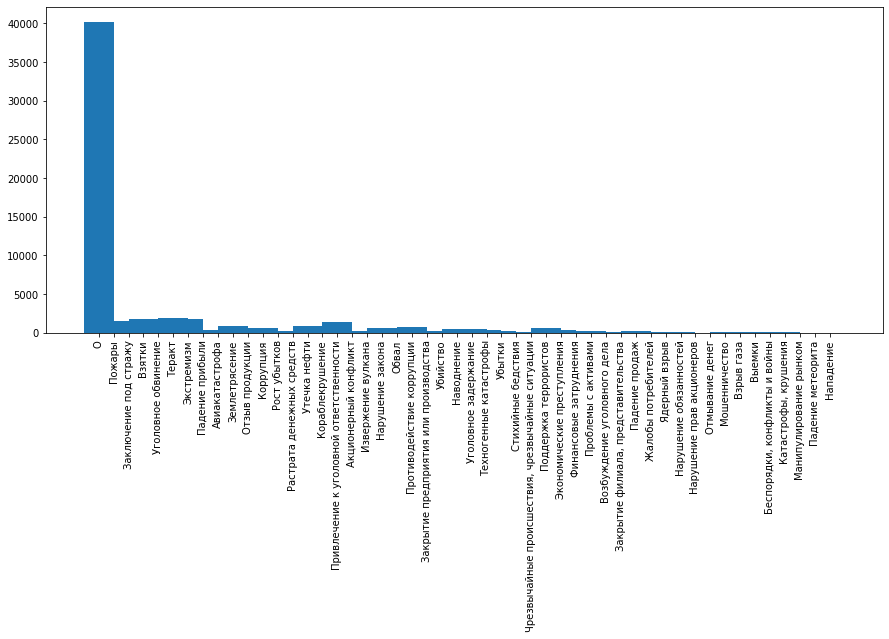

In [16]:
# Видно, что данные сильно не сбалансированны

from collections import Counter
counter = Counter(train['class'])
plt.figure(figsize=(15, 6))
plt.bar(counter.keys(), counter.values(), width=2)
plt.xticks(rotation=90)
plt.show()

In [17]:
test = pd.read_csv('../input/scan-classification-challange/df_test.csv', index_col=0)
test.sample(3)

,text,class
32903,Накануне получения стипендии Филимонов поддерж...,O
1365,Росфинмониторинг: Террористы пользуются эфиром...,O
16179,В объединенной пресс-службе судов общей юрисди...,O


In [18]:
sample_submission = pd.read_csv('../input/scan-classification-challange/sample_submission.csv')

In [19]:
# Названия категорий переводим в числовой формат и записываем в отдельный столбец 

train['encoded_cat'] = train['class'].astype('category').cat.codes
train.sample(5)

,text,class,encoded_cat
13179,"- В МЧС разъяснили, как, и надо ли вообще, рыб...",O,0
58412,"""Я в полной мере несу ответственность за все, ...",O,0
1608,"Таким образом, мною написаны более одной тысяч...",Противодействие коррупции,34
37367,В районе Ниджраб провинции Каписа в результате...,Теракт,38
19727,Суд указал в качестве отягчающего обстоятельст...,Привлечение к уголовной ответственности,32


In [22]:
train[['class', 'encoded_cat']].value_counts()

class                                             encoded_cat
O                                                 0              40159
Теракт                                            38              1837
Взятки                                            5               1775
Экстремизм                                        48              1744
Уголовное обвинение                               43              1543
Пожары                                            31              1500
Привлечение к уголовной ответственности           32              1390
Землетрясение                                     12               827
Утечка нефти                                      44               799
Противодействие коррупции                         34               695
Заключение под стражу                             9                667
Поддержка террористов                             30               653
Коррупция                                         16               593
Нарушение закон

In [23]:
# Создадим функцию по очистке данных. Будем переводить слова в нижний регистр, 
# удалять стоп слова, удалять числа и раздичные знаки которые не несут смысловой нагрузки. 
# Все слова преобразуем к их первоначалоной форме (Лемматизация)

morph = pymorphy2.MorphAnalyzer()
patterns = "[A-Z|a-z|0-9!#$%&'()*+,./:“″;”<=>?@[\]^_`{|}~—\"\-•–«»]+"
stops = set(stopwords.words("russian"))
def clean(text):
    text = text.lower()
    text = re.sub(patterns, ' ', text)
    tokens = []
    for token in text.split():
        if token and token not in stops:
            token = token.strip()
            token = morph.normal_forms(token)[0]  # Лемматизация
            #token = stemmer.stem(token) # Стеммизация
            tokens.append(token)
    return ' '.join(tokens)

In [24]:
# Применим функцию очистки к train
train['clean'] = train['text'].apply(lambda x: clean(x))
train[['clean', 'text']]

,clean,text
0,продолжать кудрин лично уверенный нацпроект на...,"При этом, продолжает Кудрин, лично он уверен: ..."
1,сотрудник го отдел хранить информация работник...,Сотрудники 1-го отдела хранили информацию о ра...
2,сирийский служба безопасность пока это справля...,Сирийские службы безопасности пока с этим спра...
3,мвд сообщить днк мужчина совпасть образец найт...,"В МВД сообщили, что ДНК мужчины совпала с обра..."
4,сообщить среда пресс секретарь белый дом джена...,Об этом сообщила в среду пресс-секретарь Белог...
...,...,...
59995,представлять тяжело находиться беларусь постоя...,"Я не представляю, как тяжело вам сейчас находи..."
59996,рамка возбудить уголовный дело дать правовой о...,"""В рамках уже возбужденного уголовного дела бу..."
59997,заявить руководитель национальный центральный ...,Об этом заявил руководитель национального цент...
59998,ранее лайф рассказывать тёмный дело мушвиг абд...,Ранее Лайф рассказывал о темных делах Мушвига ...


In [25]:
# Применим функцию очистки также для тестовых данных

test['clean'] = test['text'].apply(lambda x: clean(x))

In [26]:
# Выделим X, y. X - это будет, наш обработанный текст, y -  наш класс

y = train.encoded_cat.values
X = train.drop(['encoded_cat', 'text'], axis=1)

In [27]:
## Разделим все данные на train test в соотношении 80/20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y) # stratify=y

## Преобразуем наши текстовые данны в токены.

In [28]:
## CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

X_train_review_bow = vect.fit_transform(X_train['clean'])
X_test_review_bow = vect.transform(X_test['clean'])
X_sub_rev_bow = vect.transform(test['clean'])
#X_train_review_bow = vect.fit_transform(X_train)
#X_test_review_bow = vect.transform(X_test)

print('X_train_review_bow shape: ', X_train_review_bow.shape)
print('X_test_review_bow shape: ', X_test_review_bow.shape)
print('X_sub_review_bow shape: ', X_sub_rev_bow.shape)

X_train_review_bow shape:  (47521, 40244)
X_test_review_bow shape:  (11881, 40244)
X_sub_review_bow shape:  (40000, 40244)


## Tf-Idf
Tf-Idf расшифровывается как частота термина, обратная частоте документа, и вместо вычисления количества каждого слова в каждом документе набора данных (Bow) он вычисляет нормализованное количество, где каждое количество слов делится на количество документов, в которых встречается это слово. .

Tf-idf(w, d)= Bow(w, d) * log(Общее количество документов/(Количество документов, в которых встречается слово w))

Если слово часто встречается в определенном документе, но не во многих других документах, наиболее вероятно, что это слово имеет особое значение для этого документа и получает большее количество, чем раньше, благодаря высокому Idf. С другой стороны, если слово появляется во многих документах, то его Idf близок к 1, а логарифм превращает 1 в 0 и уменьшает его влияние.

In [29]:
## Tf-Idf

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_review_tfidf = vectorizer.fit_transform(X_train['clean'])
X_test_review_tfidf = vectorizer.transform(X_test['clean'])
X_sub_review_tfidf = vectorizer.transform(test['clean'])

print('X_train_review_tfidf shape: ', X_train_review_tfidf.shape)
print('X_test_review_tfidf shape: ', X_test_review_tfidf.shape)
print('X_sub_review_tfidf shape: ', X_sub_review_tfidf.shape)

X_train_review_tfidf shape:  (47521, 40244)
X_test_review_tfidf shape:  (11881, 40244)
X_sub_review_tfidf shape:  (40000, 40244)


## Логистическая регрессия
После создания 80/20 разделения набора данных на поезд-тест я применил логистическую регрессию, которая представляет собой алгоритм классификации, используемый для решения задач бинарной классификации. Классификатор логистической регрессии использует взвешенную комбинацию входных признаков и пропускает их через сигмовидную функцию. Сигмовидная функция преобразует любое введенное вещественное число в число от 0 до 1.

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
y_test_arg=np.argmax(y_test)
clf = MultinomialNB()
clf.fit(X_train_review_bow, y_train)

y_pred = clf.predict(X_test_review_bow) #prediction from model
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred, average = 'micro'))
print('Precision: ', precision_score(y_test, y_pred, average = 'weighted', zero_division = 1))
print('F1: ', f1_score(y_test, y_pred, average='weighted'))

Test Accuracy:  0.8256039053951687
Recall:  0.8256039053951687
Precision:  0.8300244451512202
F1:  0.7833751015716067


In [31]:
clf = MultinomialNB()
y_test_arg=np.argmax(y_test)
clf.fit(X_train_review_tfidf, y_train)

y_pred = clf.predict(X_test_review_tfidf)
#y_pred = clf.predict(X_sub_review_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred, average='weighted'))

Test Accuracy:  0.7082737143338103
F1:  0.6065588162000777


In [32]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', random_state=42)
clf.fit(X_train_review_tfidf, y_train)

#y_pred = clf.predict(X_test_review_tfidf)
y_pred = clf.predict(X_test_review_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Test F1: ', f1_score(y_test, y_pred, average='weighted'))

Test Accuracy:  0.8846056729231546
Test F1:  0.8686038748470372


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [33]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', random_state=42)
clf.fit(X_train_review_bow, y_train)

y_pred = clf.predict(X_test_review_bow)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Test F1: ', f1_score(y_test, y_pred, average='weighted'))

Test Accuracy:  0.9083410487332716
Test F1:  0.9023306307271742


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## SMOTE

In [ ]:
""""from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
 

# evaluate a model
def evaluate_model(X, y, model):
# define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
# evaluate model
    scores = cross_val_score(model, X_train_review_tfidf, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores
 
# load the dataset
#X, y = load_dataset(full_path)
# define the model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced') #`1000
# evaluate the model
scores = evaluate_model(X_train_review_tfidf, y_train, model)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
"""

## Ngramm

In [ ]:
# CountVectorizer
vect = CountVectorizer(ngram_range=(1, 2))

X_train_review_bow = vect.fit_transform(X_train['clean'])
X_test_review_bow = vect.transform(X_test['clean'])
X_sub_rev_bow = vect.transform(test['clean'])

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C = 10, random_state=42)
clf.fit(X_train_review_bow, y_train)

y_pred = clf.predict(X_test_review_bow)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Test F1: ', f1_score(y_test, y_pred, average='weighted'))

In [ ]:
# HashingVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer(ngram_range=(1, 3))

X_train_review_hv = vectorizer.fit_transform(X_train['clean'])
X_test_review_hv = vectorizer.transform(X_test['clean'])
X_sub_review_hv = vectorizer.transform(test['clean'])

In [ ]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', random_state=42)
clf.fit(X_train_review_hv, y_train)

y_pred = clf.predict(X_test_review_hv)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

## Попробуем другие модели из sklearn

In [34]:
# C-классификация опорных векторов

from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train_review_bow, y_train)
y_pred_svc = svclassifier.predict(X_test_review_bow)
print('Test Accuracy: ', accuracy_score(y_test, y_pred_svc))
print('Test F1: ', f1_score(y_test, y_pred, average='weighted'))

Test Accuracy:  0.9068260247453918
Test F1:  0.9023306307271742


In [35]:
# Классификатор, реализующий голосование k ближайших соседей

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train_review_bow, y_train)
y_pred = knn.predict(X_test_review_bow)

print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Test F1: ', f1_score(y_test, y_pred, average='weighted'))

Test Accuracy:  0.7929467216564262
Test F1:  0.7460008690432889


## Гиперпараметры

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', penalty='l2', random_state=42)
#penalty = ['l1','l2']
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
grid = dict(alpha=alpha)
c_values = [100, 10, 1.0]
#param_grid = {'C':[1, 10]}
param_grid = dict(C=c_values, solver=solver)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, verbose=10, cv=cv, scoring='accuracy', error_score=0)
grid_search.fit(X_train_review_bow, y_train)
#print("Best: %f using %s" % (grid_search.best_params_))

### Попробуем обучить с полученными гипер параметрами 

In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty='l2', C = 10, random_state=42)
clf.fit(X_train_review_bow, y_train)

y_pred = clf.predict(X_test_review_bow)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Test F1: ', f1_score(y_test, y_pred, average='weighted'))

Test Accuracy:  0.9085935527312515
Test F1:  0.904095402384893


In [37]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l2', C = 100, random_state=42)
clf.fit(X_train_review_bow, y_train)

y_pred = clf.predict(X_test_review_bow)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Test F1: ', f1_score(y_test, y_pred, average='weighted'))

Test Accuracy:  0.9105294167157647
Test F1:  0.905973173119797


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


 С подобранными гиперпараметрами получилось улучшить модель до 0.897

### делаем предсказание на Test и выкладываем на Kaggle

In [ ]:
clf = MultinomialNB(alpha=1)
clf.fit(X_train_review_tfidf, y_train)

y_pred = clf.predict(X_sub_review_tfidf)
#print('Test Accuracy: ', accuracy_score(y_test, y_pred))

In [ ]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train_review_bow, y_train)
y_pred_svc = svclassifier.predict(X_sub_review_tfidf)

In [ ]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_review_tfidf, y_train)

#y_pred = clf.predict(X_test_review_tfidf)
y_pred = clf.predict(X_sub_review_tfidf)
#print('Test Accuracy: ', accuracy_score(y_test, y_pred))

In [ ]:
clf = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l2', C = 100, random_state=42)
clf.fit(X_train_review_bow, y_train)

y_pred = clf.predict(X_sub_rev_bow)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['class'].unique())
#list(le.classes_)
num = le.transform(train['class'].unique())


In [ ]:
y_sub = list(le.inverse_transform(y_pred))

In [ ]:
#sub_predict = model.predict(X_sub)
sample_submission['class'] = y_sub
sample_submission.to_csv('LR_submission.csv', index=False)

# Bert

## Fine Tuning DistilBERT TensorFlow

In [30]:
#!pip uninstall transformers --yes
#!pip uninstall h5py

!pip install transformers
#!pip install h5py==2.10.0
!pip install pytorch
!pip install pytorch-transformers

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 36, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-gijbvg09/pytorch_ba0109216fa74cd997f1697a290b6ed9/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
  Running setup.py install for pytorch ... error
  error: subprocess-exited-with-error
  
  × Running setup.py install for pytorch did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback

In [40]:
import transformers
from transformers import DistilBertTokenizer
from transformers import DistilBertModel, DistilBertConfig
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
#import pandas as pd
import json
import gc
#import numpy as np

In [41]:
# Токенизируем текст 
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
X_train_encodings = tokenizer(X_train['clean'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test['text'].to_list(), truncation=True, padding=True)

X_test_encodings = tokenizer(X_test['clean'].to_list(), truncation=True, padding=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [42]:
y_sub = np.zeros(len(test))
y_sub.shape

(40000,)

In [43]:
# Создает dataset с тонекизированными данными

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((dict(X_test_encodings), 
                                    list(y_test))) 
val_class = np.zeros(len(test))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    val_class))

2022-06-25 05:25:50.756551: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [44]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=50)
losss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5) # 2e-5
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy']) # loss=model.compute_loss

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-06-25 05:29:13.877840: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint 

In [ ]:
model.fit(train_dataset.shuffle(1000).batch(16), 
          epochs=1,
          validation_data=test_dataset.shuffle(1000).batch(16))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:376: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)
2022-06-25 05:29:28.569321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


 960/2971 [========>.....................] - ETA: 8:16:18 - loss: 1.5937 - accuracy: 0.6802